<a href="https://colab.research.google.com/github/Zdestrion/ML_pvt_repo/blob/master/NB_CNN_visualizzazione_TL_LC4_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Tecniche avanzate DNN: metodi di visulaizzazione di una CNN e Transfer Learning

### Informazioni ###

scopo: 
- apprendere alcune delle tecniche di xAI basate sulla visualizzazione attraverso l'applicazione ad una rete neurale convoluzionale addestrata in classificazione
- come sfruttare una CNN allo stato-dell-arte addestrata su ImageNet tramite techniche di transfer learning

DL tool: tensorflow/keras

**Dataset:**

Sign Language Digits Dataset 
(Turkey Ankara Ayrancı Anadolu High School Students: [github-link](https://github.com/ardamavi/Sign-Language-Digits-Dataset))

Image size: 100 x 100 pixels 

Color space: RGB

Number of classes: 10 (Digits: 0-9)

Number of participant students: 218

Number of samples per student: 10

In [0]:
# è necessario installare la nightly di tensorflow per accedere ad alcune funzioni 
# per l'accesso ai dati ancora in fase di test (disponibili a breve)
!pip install tf-nightly

In [0]:
# download dei dataset:
!rm -rf Dataset.zip
!rm -rf Dataset_test.zip
!rm -rf Dataset
!rm -rf Dataset_test
!rm -rf __MACOSX
!wget http://giagu.web.cern.ch/giagu/CERN/Dataset.zip
!wget http://giagu.web.cern.ch/giagu/CERN/Dataset_test.zip

--2020-06-02 17:16:51--  http://giagu.web.cern.ch/giagu/CERN/Dataset.zip
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.101.49, 2001:1458:d00:35::100:35
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.101.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11254421 (11M) [application/zip]
Saving to: ‘Dataset.zip’

Dataset.zip         100%[===================>]  10.73M  1.49MB/s    in 14s     

2020-06-02 17:17:06 (782 KB/s) - ‘Dataset.zip’ saved [11254421/11254421]

--2020-06-02 17:17:09--  http://giagu.web.cern.ch/giagu/CERN/Dataset_test.zip
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.101.49, 2001:1458:d00:35::100:35
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.101.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5903386 (5.6M) [application/zip]
Saving to: ‘Dataset_test.zip’

Dataset_test.zip    100%[===================>]   5.63M   803KB/s    in 12s     

2020-06-02 17:17:22 (470 K

In [0]:
# unzip
!unzip -q Dataset.zip
!unzip -q Dataset_test.zip
!ls 

checkpoint			result_cam8.jpg
Dataset				result_cam9.jpg
Dataset_test			result_cam.jpg
Dataset_test.zip		sample_data
Dataset.zip			TLcnn_best.data-00000-of-00002
__MACOSX			TLcnn_best.data-00001-of-00002
model.png			TLcnn_best.index
mycnn_best.data-00000-of-00002	XC_1_cnn_best.data-00000-of-00002
mycnn_best.data-00001-of-00002	XC_1_cnn_best.data-00001-of-00002
mycnn_best.index		XC_1_cnn_best.index
result_cam10.jpg		XC_2_cnn_best.data-00000-of-00002
result_cam11.jpg		XC_2_cnn_best.data-00001-of-00002
result_cam12.jpg		XC_2_cnn_best.index
result_cam13.jpg		XC_3_cnn_best.data-00000-of-00002
result_cam14.jpg		XC_3_cnn_best.data-00001-of-00002
result_cam1.jpg			XC_3_cnn_best.index
result_cam2.jpg			XC_cnn_best.data-00000-of-00002
result_cam3.jpg			XCcnn_best.data-00000-of-00002
result_cam4.jpg			XC_cnn_best.data-00001-of-00002
result_cam5.jpg			XCcnn_best.data-00001-of-00002
result_cam6.jpg			XC_cnn_best.index
result_cam7.jpg			XCcnn_best.index


Dentro il folder Dataset sono contenute le immagini dei vari digit in subfolder con nome il numero del digit corrispondente

In [0]:
!ls Dataset/
!ls Dataset_test/

0  1  2  3  4  5  6  7	8  9
0  1  2  3  4  5  6  7	8  9


### Procedura ###

Passi tipici nella costruzione di una procedura end-to-end per lo sviluppo di una CNN (o generica DNN):

1.   lettura e pre-processamento dei dati
2.   definizionedel modello di ANN e della sua architettura
3.   scelta dell'ottmizzatore e della funzione di loss
4.   training del modello
5.   misura delle prestazioni del modello su dati non utilizzati nel training (test data)
6.   modifica degli iperparametri per ottimizzare le prestazioni per il dataset specifico (hyperparameter tuning)

In [0]:
#import models & layers from TF/keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Helper libraries
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable

print(tf.__version__)

2.3.0-dev20200602


Lettura del dataset

Keras ha anche varie utility che permettono di leggere automaticamente immagini o file di testo e convertirli nei formati utili *tf.keras.preprocessing.image_dataset_from_directory* o *tf.keras.preprocessing.text_dataset_from_directory*.

Qui useremo *tf.keras.preprocessing.image_dataset_from_directory*

In [0]:
#definiamo la size delle immagini (sono 100x100) e la batch size con cui vengono lette dal disco in gruppi
image_size = (100, 100)
batch_size = 32

#80% delle immagini usate per training - 20% per validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=4321,
    image_size=image_size,
    batch_size=batch_size,
)
vali_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=4321,
    image_size=image_size,
    batch_size=batch_size,
)

#lettura dataset di test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset_test",
    label_mode='categorical',
    seed=4321,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1157 files belonging to 10 classes.
Using 926 files for training.
Found 1157 files belonging to 10 classes.
Using 231 files for validation.
Found 905 files belonging to 10 classes.


Visualizziamo i dati per verifcarne il contenuto

In [0]:
# train_ds.take(1) fornisce un "batch" di immagini dal campione nel nostro caso 32 immagini
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)

(32, 100, 100, 3)
(32, 10)


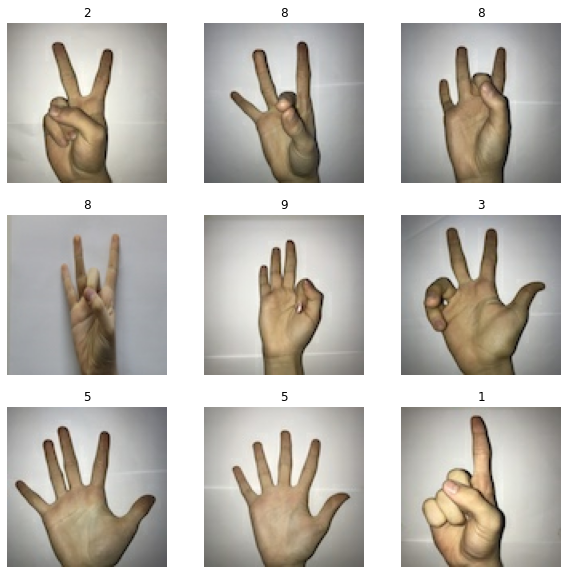

In [0]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")

**Normalizzazione delle immagini**

È utile normalizzare tra [0,1] i tre canali RGB delle immagini in input. Tuttavia è conveniente fare questa operazione direttamente nel modello TF/keras usando un layer opportuno di normalizzazione in modo da sfruttare l'accelerazione della GPU per l'operazione 

In [0]:
#ottimizzazione dei dataset caching e prefetching per I/O su disco

train_ds = train_ds.prefetch(buffer_size=32)
vali_ds = vali_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

**Creazione del Modello CNN**

Usiamo functional API di Keras

Model: "VGGlike_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_131 (InputLayer)       [(None, 100, 100, 3)]     0         
_________________________________________________________________
rescaling_25 (Rescaling)     (None, 100, 100, 3)       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 98, 98, 16)        448       
_________________________________________________________________
ReLU_1 (ReLU)                (None, 98, 98, 16)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 49, 49, 16)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 47, 47, 16)        2320      
_________________________________________________________________
ReLU_2 (ReLU)                (None, 47, 47, 16)        

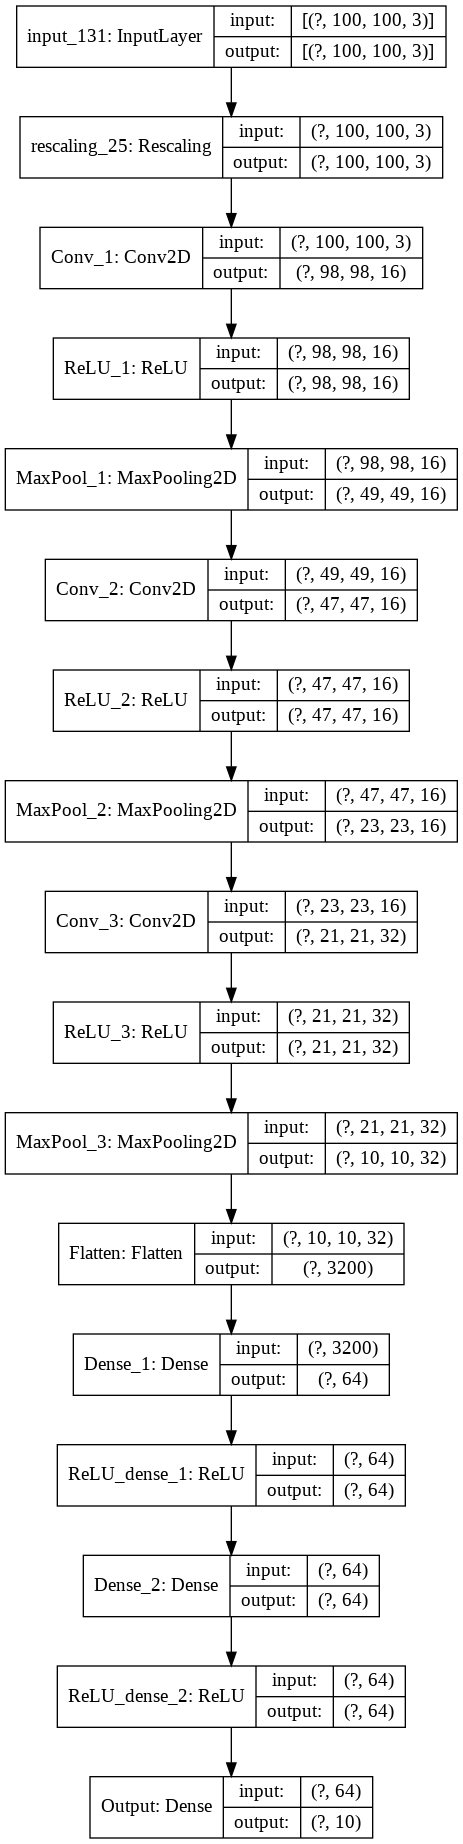

In [0]:
# Model definition (functional model)

# definizione input (immagini costituite da tensori 100x100x3)
inputs = keras.Input(shape=(100,100,3))

# Normalizzazione [0,1]
x = layers.experimental.preprocessing.Rescaling(1.0/255)(inputs)


# Simple CNN:
#
# primo blocco Convoluzionale
x = keras.layers.Conv2D(16, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.ReLU(name='ReLU_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco Convoluzionale
x = keras.layers.Conv2D(16, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.ReLU(name='ReLU_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale 
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.ReLU(name='ReLU_3')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 10 neuroni con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

# Classificatore
x = keras.layers.Dense(64, name='Dense_1')(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)
x = keras.layers.Dense(64, name='Dense_2')(x)
x = keras.layers.ReLU(name='ReLU_dense_2')(x)
outputs = keras.layers.Dense(10, activation='softmax', name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='VGGlike_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# Definizione dei parametri di training del modello:
# * Loss function: 
# * Optimizer:
# * Metric: 

# Parametri:

# learning rate per Adam
LR_ST=1e-3

# Ottimizzatore: 
#adam: adaptive moment estimation (SGD con learning adattivo del gradiente e 
# del momento secondo + momentum )
#tf.keras.optimizers.Adam(
#    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
#    name='Adam', **kwargs
#)

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function:
# We expect labels to be one-hot representation, then use CategoricalCrossentropy loss.

# Metrica:
# Accuracy

# Eagerly RUN:
# di default Tensorflow ottimizza in modo spinto il modello che abbiamo progettato
# e trasforma il modello in un grafo diretto acicliclo computazionale altamente 
# ottimizzato per girare nel minor tempo possibile. Questo significa che non è 
# il codice python che abbiamo scritto sopra ad essere in realtà esegeuito. Questo
# può creare difficoltà con il debugging se ci sono problemi. Se sidesidera 
# eseguire esattamente il python scritto basta settare run_eagerly=True. Il prezzo
# da pagare è una esecuzioen estremamente più lenta (is usa solo in debug) 

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

# Parametr: frazione eventi validation set, batch size, numero epoche, ...

# Callbacks:
# tramite le callbacks possiamo interagire durante il run-time con il modello.
# Per esempio possiamo modificare il larnign rate facendolo decadere (diminuire) 
# nel tempo, o possiamo dire al modello di salvare i pesi ad ogni epoca o quando 
# la validation loss raggiunge il suo valore minimo etc..
# Le callback vengono chiamate all'inizio di ogni epoca o all'inizio di ogni 
# mini-batch a seconda dello scopo ...

# callback per avere un leraning rate variabile

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_best',
        monitor='val_accuracy',
        save_weights_only=True, 
        save_best_only=True,
        save_freq='epoch')

# metto tutte le callback in una lista
callbacks = [ lr_scheduler, model_checkpoint ]    

history = model.fit(train_ds, epochs=20,
                    validation_data=vali_ds, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/20
29/29 [==============================] - 1s 40ms/step - loss: 2.2938 - accuracy: 0.1080 - val_loss: 2.2297 - val_accuracy: 0.1688
Epoch 2/20
29/29 [==============================] - 1s 36ms/step - loss: 2.0376 - accuracy: 0.2797 - val_loss: 1.6149 - val_accuracy: 0.4805
Epoch 3/20
29/29 [==============================] - 1s 36ms/step - loss: 1.2266 - accuracy: 0.5842 - val_loss: 1.0552 - val_accuracy: 0.6234
Epoch 4/20
29/29 [==============================] - 1s 35ms/step - loss: 0.8533 - accuracy: 0.7235 - val_loss: 0.7261 - val_accuracy: 0.7662
Epoch 5/20
29/29 [==============================] - 1s 36ms/step - loss: 0.7103 - accuracy: 0.7538 - val_loss: 0.6698 - val_accuracy: 0.7922
Epoch 6/20
29/29 [==============================] - 1s 35ms/step - loss: 0.5835 - accuracy: 0.7981 - val_loss: 0.5965 - val_accuracy: 0.8052
Epoch 7/20
29/29 [==============================] - 1s 33ms/step - loss: 0.4520 - accuracy: 0.8607 - val_loss: 0.5680 - val_accuracy: 0.7965
Epoch 8/20
29

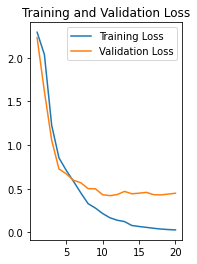

Text(0.5, 1.0, 'Training and Validation Accuracy')

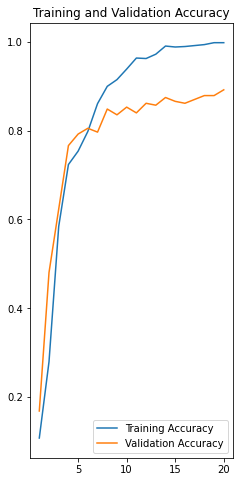

In [0]:
#plot della loss e della accuracy durante il training

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [0]:
# carichiamo i parametri del modello migliore sul validation set 
model.load_weights('mycnn_best')

In [0]:
#checks accuracy and loss on test sample

test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)

29/29 - 1s - loss: 0.4867 - accuracy: 0.8895

Test loss: 0.4867115318775177

Test accuracy: 0.889502763748169


**Visualizzazione rappresentazioni apprese dalla CNN**

*   visualizzazione dell'uscita delle attivazioni dei vari layes 
*   visualizzazione dei filtri appresi dalla rete
*   Heatmaps


(100, 100, 3)


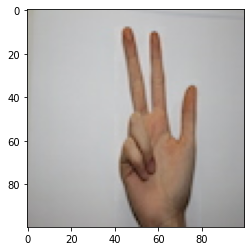

In [0]:
#visualizzazione dell'uscita delle attivazioni dei vari layes

#implementazione:
# 1 si prende un'immagine di esempio (di quelle del validation/test set)
# 2 si costruisce un modello che prende l'immagine in input e restituisce tensori contenenti le uscite di tutte le
#   funzioni di attivazione dei vary later della rete
# 3 si graficano le attivazioni ottenute ...

from IPython.display import Image
import matplotlib.pyplot as plt
import cv2

#prendiamo un'immagine a caso del validation set
for images,labels in train_ds.take(1):
   immagine = images[6].numpy().astype("uint8")
print(immagine.shape)

plt.imshow(immagine) 
plt.show()

In [0]:
#salviamo i nomi di tutti i layers della rete nella lista layer_names
layer_names = []
for layer in model.layers[:20]:
    layer_names.append(layer.name)
print(layer_names)

# estraiamo gli output da tutti i 20 layers della nostra rete
layer_outputs = [layer.output for layer in model.layers[:20]]

# instanziamo un semplice modello keras che prende l'immagine in input e restituisce 
# tali output (le attivazioni)

activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

['input_131', 'rescaling_25', 'Conv_1', 'ReLU_1', 'MaxPool_1', 'Conv_2', 'ReLU_2', 'MaxPool_2', 'Conv_3', 'ReLU_3', 'MaxPool_3', 'Flatten', 'Dense_1', 'ReLU_dense_1', 'Dense_2', 'ReLU_dense_2', 'Output']


In [0]:
#trasformiamo l'immagine in modo che abbia la shape di tensore numpy adatta alla 
#nostra rete (1,100,100,3) con primo indice l'indice di evento (l'immagine singola
#non ha questo primo indice ovviamente)
immagine = np.reshape(immagine, (1,100,100,3))

# e estraiamone le attivazioni
activations = activation_model.predict(immagine)

(1, 98, 98, 16)


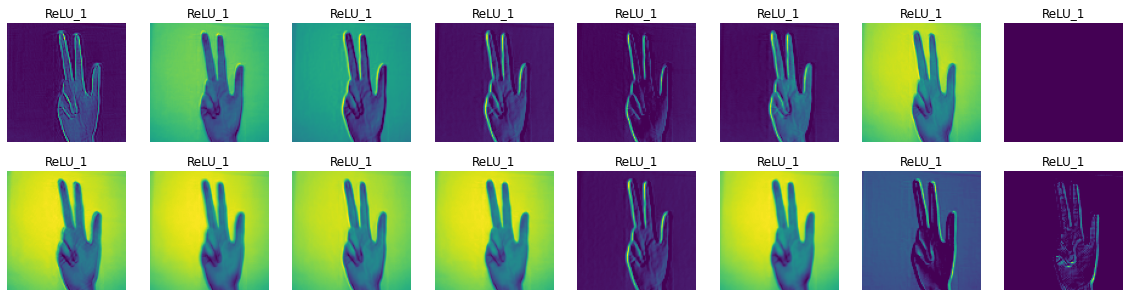

In [0]:
# grafichiamo gli output per il primo layer convoluzionale (è il layer numero 
# 3 (dopo ReLU) nel nostro modello)

first_layer_activation = activations[3]
print(first_layer_activation.shape)

k = 0
plt.figure(figsize=(20, 5), frameon=False)

for i in range(8):
   for j in range(2):
      ax = plt.subplot(2, 8, k + 1, sharex=ax)
      plt.imshow(first_layer_activation[0, :, :, k], cmap='viridis') 
      plt.axis("off")
      plt.grid(False)
      plt.title(layer_names[3])
      k = k + 1

(1, 21, 21, 32)


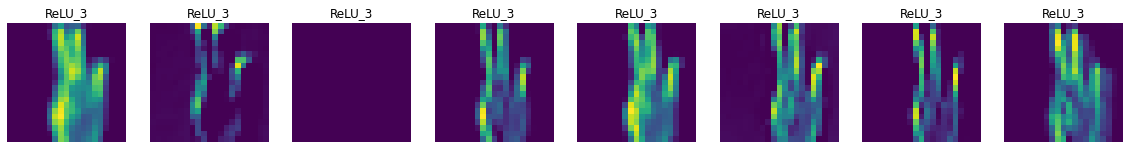

In [0]:
# stessa cosa per il terzo layer convoluzionale (il 9 nella lista)
# sono 32 filtri, per velocità e semplicità ne grafichiamo solo i primi 
# 8)
tird_layer_activation = activations[9]
print(tird_layer_activation.shape)

k = 0
plt.figure(figsize=(20, 20), frameon=False)

for i in range(8):
    ax = plt.subplot(1, 8, k + 1, sharex=ax)
    plt.imshow(tird_layer_activation[0, :, :, k], cmap='viridis') 
    plt.axis("off")
    plt.grid(False)
    plt.title(layer_names[9])
    k = k + 1

In [0]:
#visualizzazione dei filtri appresi

#implementazione:
# 1 si prendono i pesi del layer convoluzionale selezionato  
# 2 si normalizzano i valori tra 0 e 1 per facilitarne la visualizzazione 
# 3 si plottano i risultati

Filtri layer convoluzionale:  Conv_1


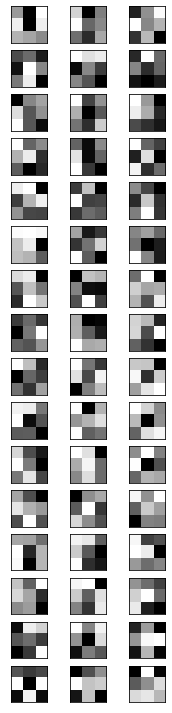

Filtri layer convoluzionale:  Conv_2


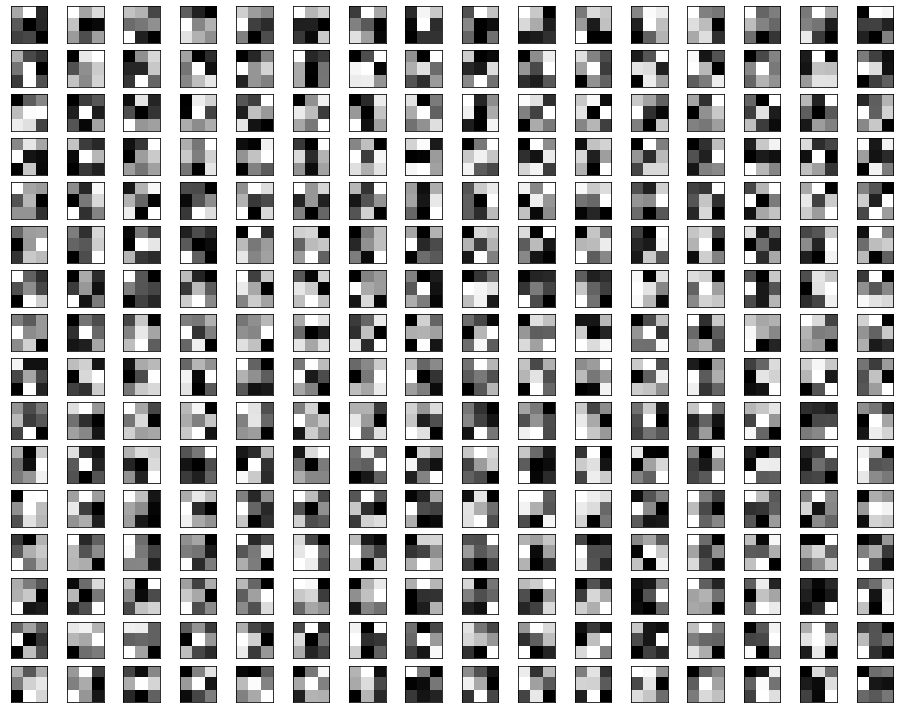

Filtri layer convoluzionale:  Conv_3


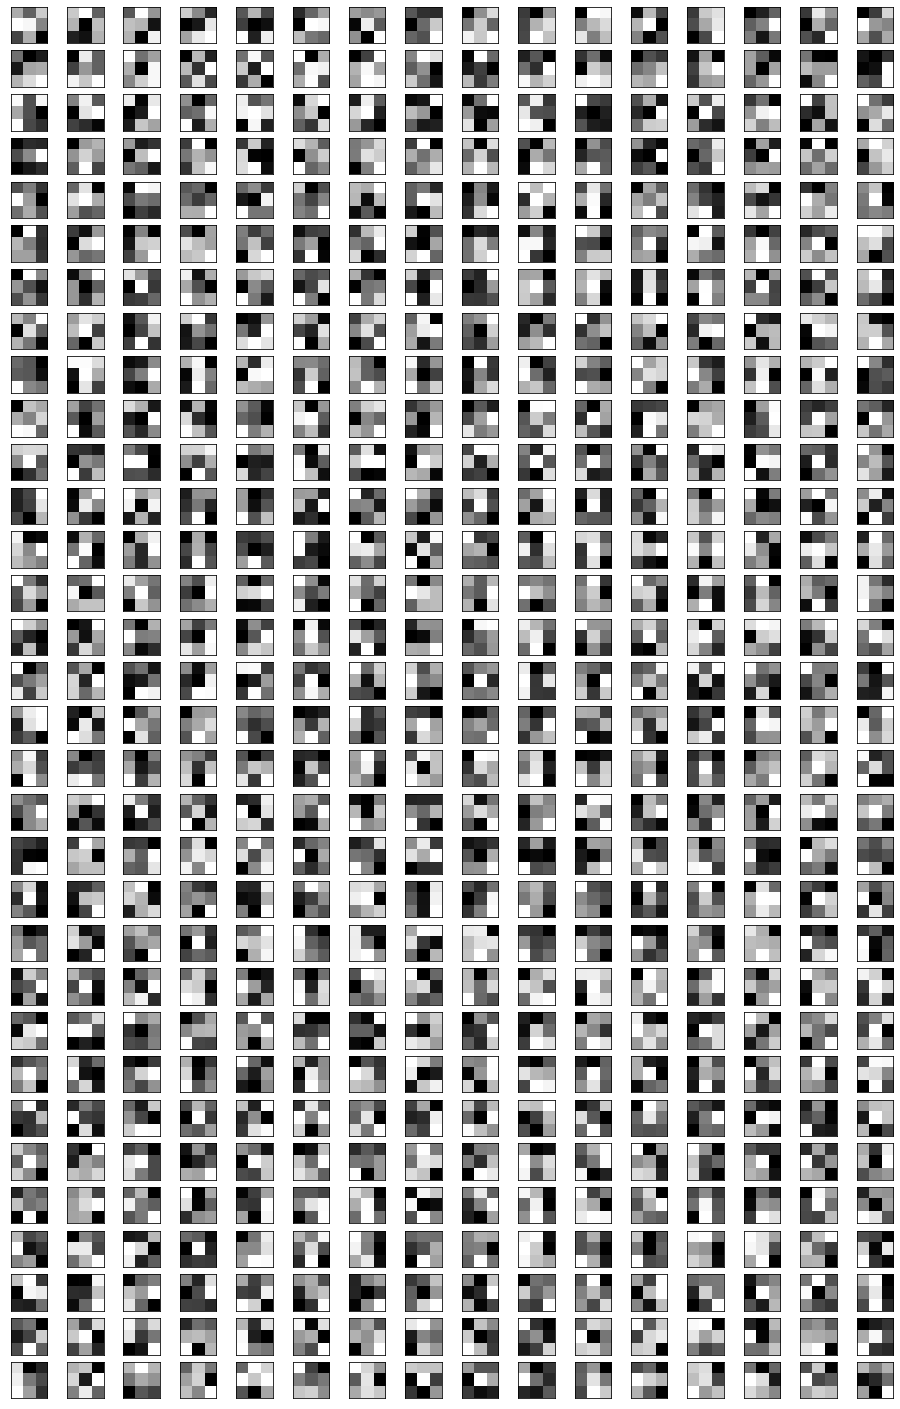

In [0]:
# plot dei filtri
# quadrati scuri indicano pesi piccoli (inibitori) del filtro
# quadrati chiari indicano pesi grandi (eccitatori) del filtro 
# diferenze tra filtri sulla stessa riga significa effetti diversi nei diversi canali in input
# Conv_1 3 canali (RGB), Conv_2 16 filtri in input ...

for layerc in ['Conv_1', 'Conv_2', 'Conv_3']:
    print('Filtri layer convoluzionale: ', layerc)
    # pesi del layer selezionato:
    filters, biases = model.get_layer(layerc).get_weights()
    # numero dei filtri 
    n_filters = filters.shape[3]
    # numero canali 
    n_channels = filters.shape[2]
    # normalizzazione in [0,1] per rendere più chiaro il plot
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    k = 1
    plt.figure(figsize=(n_channels, n_filters*0.8), frameon=False)
    for i in range(n_filters):
        f = filters[:, :, :, i]
        # plot del filtro per ogni canale RGB
        for j in range(n_channels):
            ax = plt.subplot(n_filters, n_channels, k)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(f[:, :, j], cmap='gray')
            k = k + 1

    plt.show()

In [0]:
#Heatmaps (GradCAM: Gradient-based Class Activation Map)

#implementazione (Keras/F.Chollet)
# 1 si prende la mappa di feature in uscita da un dato layer di convoluzione e si pesa 
#   ogni canale di tale mappa con il gradiente della classe rispetto a quel canale (i.e. 
#   si calcola la mappa spaziale di quanto una data immagine di input attiva una data classe)

In [0]:
#Grad-CAM Algorithm (https://arxiv.org/pdf/1610.02391.pdf)

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


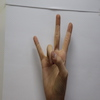

In [0]:
#prendiamo un'immagine a caso del validation set

img_orig = keras.utils.get_file("IMG_1216.JPG", "http://giagu.web.cern.ch/giagu/CERN/IMG_1216.JPG")
# immagini scaricabili http://giagu.web.cern.ch/giagu/CERN/...
#IMG_1216.JPG
#IMG_4065.JPG
#IMG_4231.JPG
#IMG_4310.JPG
#IMG_4774.JPG
#IMG_4797.JPG
#IMG_5193.JPG
#IMG_5299.JPG
#IMG_5579.JPG
#IMG_5648.JPG
#IMG_5765.JPG
#IMG_5996.JPG
#image_1.jpg 
#image_2.jpg

display(Image(img_orig))

In [0]:
# Preparazione immagine

img_size = (100,100)
img_tmp = keras.preprocessing.image.load_img(img_orig, target_size=img_size)
img_inp = keras.preprocessing.image.img_to_array(img_tmp) #->float32 Numpy array
img_inp = np.expand_dims(img_inp, axis=0) #(100,100,3) -> (1,100,100,3)

Classe predetta: 7


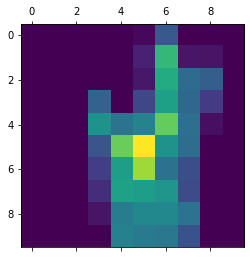

In [0]:
# Printout quale è la classe predetta 

preds = model.predict(img_inp)
print("Classe predetta:", np.argmax(preds))

# Generate class activation heatmap
last_conv_layer_name = "MaxPool_3"
classifier_layer_names = [
    "Flatten",
    "Dense_1",
    "ReLU_dense_1",
    "Dense_2",
    "ReLU_dense_2",
    "Output",
]


heatmap = make_gradcam_heatmap(
    img_inp, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

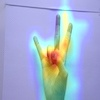

In [0]:
from IPython.display import Image
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_orig)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
save_path = "result_cam.jpg"
cv2.imwrite(save_path, superimposed_img)

display(Image(save_path))

# Confronto delle prestazioni della rete rispetto ad una CNN stato-dell-arte addestrata su ImageNet + transfer learning



In [0]:
#Prendiamo la rete VGG16 addestrata su ImageNet

#estraiamo solo il base-model (i.e. i layer convoluzionali)

base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(200, 200, 3), #NOTA IMPORTANTE: una rete pre-trainata lo è stata con immagini di una certa size
    #dovremo modificare opportuanamente le nostre immagini (100,100,3) per accordarsi con l'input
    #voluto
    include_top=False)  # Do not include the ImageNet classifier at the top.

#Congeliamo i layer convoluzionali del modello base
base_model.trainable = False

In [0]:
#Costruiamo un modello di classificazione on top del modello trainato (per esempio
#simile a quello che abbiamo usato per la nostra rete CNN)

inputs_TL = keras.Input(shape=(200, 200, 3))

# Normalizzazione [0,1]
x = layers.experimental.preprocessing.Rescaling(1.0/255)(inputs_TL)

# blocco di feature-extraction dato da Xception

x = base_model(inputs_TL, training=False)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

# Classificatore
x = keras.layers.Dense(64, name='Dense_1')(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)
x = keras.layers.Dense(64, name='Dense_2')(x)
x = keras.layers.ReLU(name='ReLU_dense_2')(x)
outputs_TL = keras.layers.Dense(10, activation='softmax', name='Output')(x)

#definizione del modello
model_TL = keras.Model(inputs=inputs_TL, outputs=outputs_TL, name='FineTuned_VGG16')

#printout il summary del modello
model_TL.summary()

Model: "FineTuned_VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_134 (InputLayer)       [(None, 200, 200, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
Flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
Dense_1 (Dense)              (None, 64)                1179712   
_________________________________________________________________
ReLU_dense_1 (ReLU)          (None, 64)                0         
_________________________________________________________________
Dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
ReLU_dense_2 (ReLU)          (None, 64)            

In [0]:
# preprocessamento dei dati
#definiamo la size delle immagini (sono 100x100) e la batch size con cui vengono lette dal disco in gruppi
image_size = (100, 100)
batch_size = 32

#80% delle immagini usate per training - 20% per validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=4321,
    image_size=image_size,
    batch_size=batch_size,
)
vali_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=4321,
    image_size=image_size,
    batch_size=batch_size,
)

#lettura dataset di test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset_test",
    label_mode='categorical',
    seed=4321,
    image_size=image_size,
    batch_size=batch_size,
)

#trasformiamoli nella size richiesta
size = (200, 200)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
vali_ds = vali_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

#ottimizzazione dei dataset caching e prefetching per I/O su disco
train_ds = train_ds.prefetch(buffer_size=32)
vali_ds = vali_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

Found 1157 files belonging to 10 classes.
Using 926 files for training.
Found 1157 files belonging to 10 classes.
Using 231 files for validation.
Found 905 files belonging to 10 classes.


In [0]:
# Compilazione del modello
LR_ST=1e-3
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
EAGERLY = False

model_TL.compile(optimizer=OPTIMIZER,
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

lr_scheduler2 = keras.callbacks.LearningRateScheduler(lr_decay)
model_checkpoint2 = keras.callbacks.ModelCheckpoint(
        filepath='TLcnn_best',
        monitor='val_accuracy',
        save_weights_only=True, 
        save_best_only=True,
        save_freq='epoch')

# metto tutte le callback in una lista
callbacks = [ lr_scheduler, model_checkpoint2 ]    

history = model_TL.fit(train_ds, epochs=6,
                    validation_data=vali_ds, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/6
29/29 [==============================] - 3s 102ms/step - loss: 3.0488 - accuracy: 0.5378 - val_loss: 0.8306 - val_accuracy: 0.7662
Epoch 2/6
29/29 [==============================] - 3s 97ms/step - loss: 0.3877 - accuracy: 0.8855 - val_loss: 0.3311 - val_accuracy: 0.8701
Epoch 3/6
29/29 [==============================] - 3s 91ms/step - loss: 0.1106 - accuracy: 0.9687 - val_loss: 0.4889 - val_accuracy: 0.8658
Epoch 4/6
29/29 [==============================] - 3s 97ms/step - loss: 0.0775 - accuracy: 0.9741 - val_loss: 0.4184 - val_accuracy: 0.9091
Epoch 5/6
29/29 [==============================] - 3s 99ms/step - loss: 0.0326 - accuracy: 0.9946 - val_loss: 0.4346 - val_accuracy: 0.9264
Epoch 6/6
29/29 [==============================] - 3s 97ms/step - loss: 0.0226 - accuracy: 0.9968 - val_loss: 0.2981 - val_accuracy: 0.9307


In [0]:
# carichiamo i parametri del modello migliore sul validation set 
model_TL.load_weights('TLcnn_best')

In [0]:
# seguito infine da un breve round di fine tuning globale

# decongeliamo i pesi del modello base della VGG16
#
# NOTA importante: manteniamo 'training=False' quando chiamiamo il la rete nel 
# modello, questo serve per fare in modo che i batch-normlisation layer contenuti
# in VGG16 non aggiornino la loro batch statistic distruggendo quanto appreso in 
# precedenza (per una spiegazione più dettagliata vedere: https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)

base_model.trainable = True
model_TL.summary()

LR_ST=1e-5 #usiamo un learning rate spinto e fisso visto che vogliamo mantenere il training nei dintorni del minimo trovato precedentemente
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
EAGERLY = False

model_TL.compile(optimizer=OPTIMIZER,
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=EAGERLY)

callbacks = [ model_checkpoint2 ]    
history = model_TL.fit(train_ds, epochs=5,
                    validation_data=vali_ds, shuffle=True, verbose=1,
                    callbacks=callbacks)

Model: "FineTuned_VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_134 (InputLayer)       [(None, 200, 200, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
Flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
Dense_1 (Dense)              (None, 64)                1179712   
_________________________________________________________________
ReLU_dense_1 (ReLU)          (None, 64)                0         
_________________________________________________________________
Dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
ReLU_dense_2 (ReLU)          (None, 64)            

In [0]:
#checks accuracy and loss on test sample
model_TL.load_weights('TLcnn_best')
test_loss, test_acc = model_TL.evaluate(test_ds, verbose=2)
print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)

29/29 - 2s - loss: 0.0958 - accuracy: 0.9790

Test loss: 0.09575825929641724

Test accuracy: 0.9790055155754089


# **Compiti:** 

Come solito scopo "principale" è quello di giocare con il notebook, cercando di capirne i contenuti e le tecniche impiegate

Compiti specifici:
1.   mitigare overfitting rete convoluzionale iniziale, per esempio usando layer di dropout e/o agendo sugli iperparametri
2.   costruire heatmaps delle altre immagini tra quelle scaricabili indicate nel notebook e commentare i risultati
3.   visualizzare differenti layer di attivazione e differenti filtri ecommentare i risultati
4.   provare a cambiare i modelli di reti CNN pre-addestrate verficando quale tra el disponibili fornisce prestazioni migliori (questa parte e' time-consuming, basta un'archiettura, tipo Xception, Resnet101, ...)

#Esercizio 1: Miglioramento dell'overfitting

In [0]:
#Size definition
image_size = (100, 100)
batch_size = 32

#split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=4321,
    image_size=image_size,
    batch_size=batch_size,
)
vali_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=4321,
    image_size=image_size,
    batch_size=batch_size,
)

#test set read
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset_test",
    label_mode='categorical',
    seed=4321,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1157 files belonging to 10 classes.
Using 926 files for training.
Found 1157 files belonging to 10 classes.
Using 231 files for validation.
Found 905 files belonging to 10 classes.


In [0]:
#prefetching
train_ds = train_ds.prefetch(buffer_size=32)
vali_ds = vali_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

Model: "VGGlike_CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_135 (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
rescaling_27 (Rescaling)        (None, 100, 100, 3)  0           input_135[0][0]                  
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 98, 98, 16)   448         rescaling_27[0][0]               
__________________________________________________________________________________________________
LeakyReLU_1 (LeakyReLU)         (None, 98, 98, 16)   0           Conv_1[0][0]                     
________________________________________________________________________________________

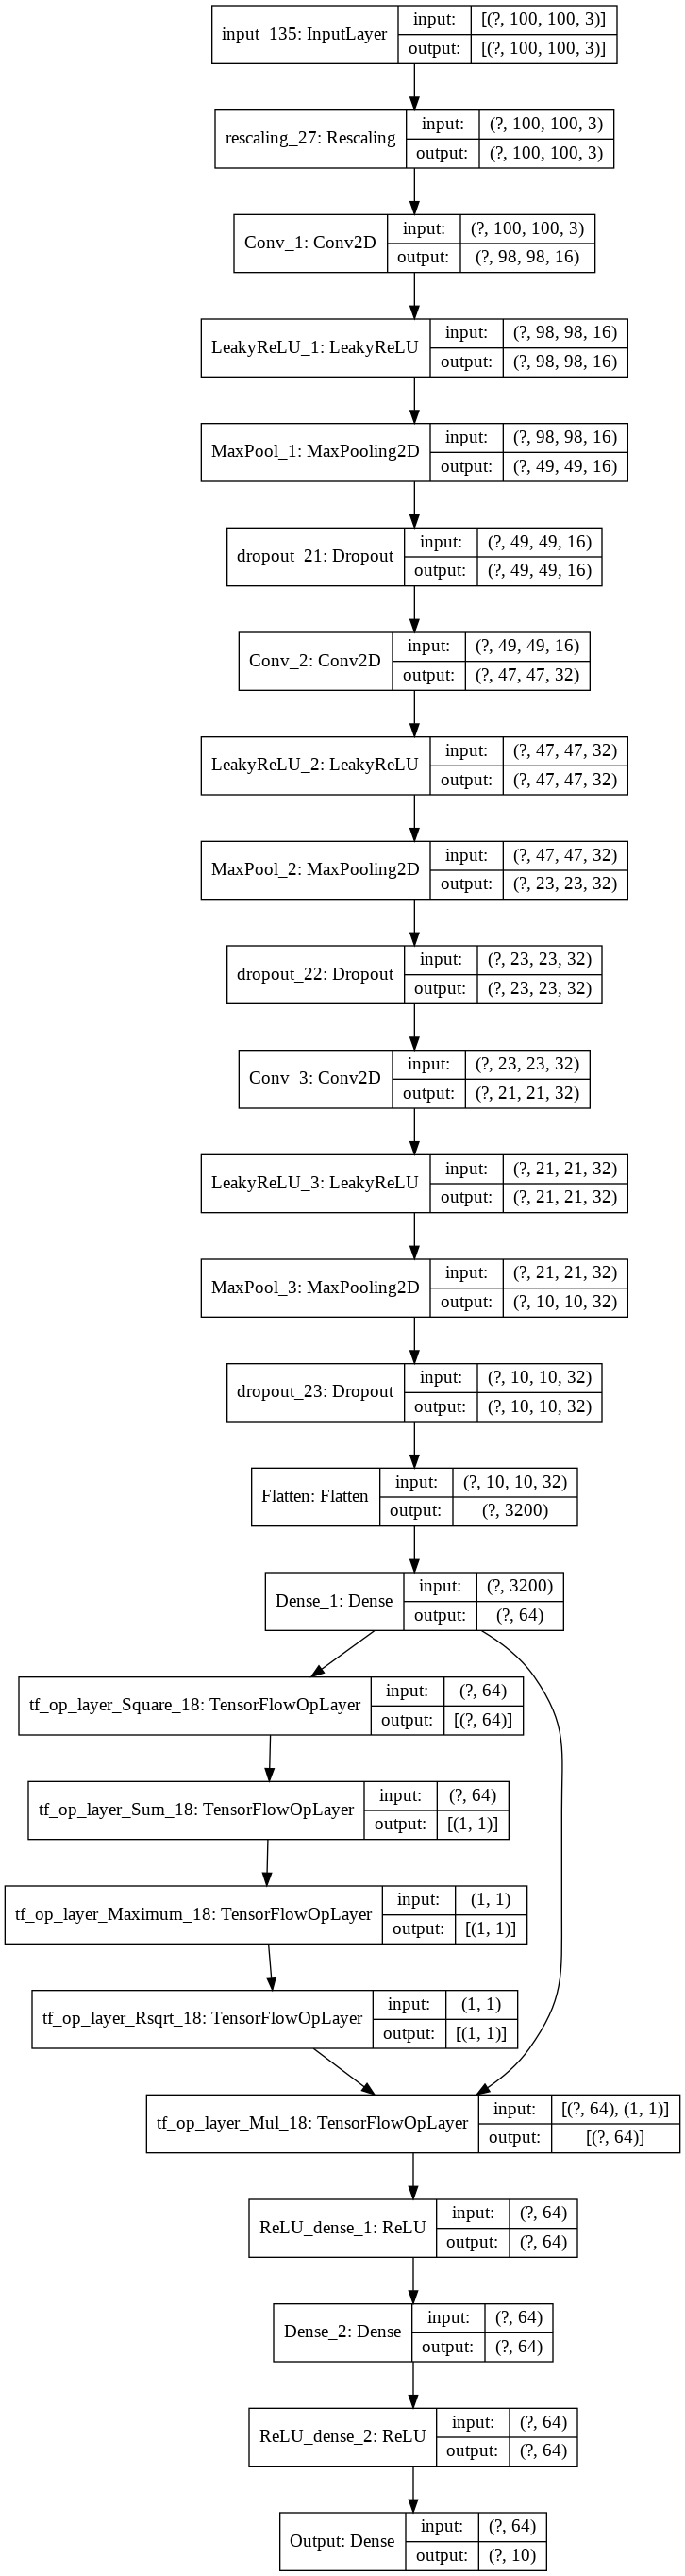

In [0]:
# Model definition (functional model)
inputs = keras.Input(shape=(100,100,3))

x = layers.experimental.preprocessing.Rescaling(1.0/255)(inputs)

# primo blocco Convoluzionale
x = keras.layers.Conv2D(16, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.LeakyReLU(name='LeakyReLU_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)
x = keras.layers.Dropout(rate=0.2)(x)

# secondo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.LeakyReLU(name='LeakyReLU_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)
x = keras.layers.Dropout(rate=0.2)(x)

# terzo blocco convoluzionale 
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.LeakyReLU(name='LeakyReLU_3')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_3')(x)
x = keras.layers.Dropout(rate=0.2)(x)

x = keras.layers.Flatten(name='Flatten')(x)

# Classificatore
x = keras.layers.Dense(64, name='Dense_1')(x)
x = keras.backend.l2_normalize(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)
x = keras.layers.Dense(64, name='Dense_2')(x)
x = keras.layers.ReLU(name='ReLU_dense_2')(x)
outputs = keras.layers.Dense(10, activation='softmax', name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='VGGlike_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# Definizione dei parametri di training del modello:
# * Loss function: 
# * Optimizer:
# * Metric: 

# Parametri:

# learning rate per Adam
LR_ST=1e-3
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function:
# We expect labels to be one-hot representation, then use CategoricalCrossentropy loss.

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_best',
        monitor='val_accuracy',
        save_weights_only=True, 
        save_best_only=True,
        save_freq='epoch')

# metto tutte le callback in una lista
callbacks = [ lr_scheduler, model_checkpoint ]    

history = model.fit(train_ds, epochs=30,
                    validation_data=vali_ds, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
29/29 [==============================] - 1s 35ms/step - loss: 2.3040 - accuracy: 0.0961 - val_loss: 2.3051 - val_accuracy: 0.0736
Epoch 2/30
29/29 [==============================] - 1s 27ms/step - loss: 2.3015 - accuracy: 0.1080 - val_loss: 2.3041 - val_accuracy: 0.0952
Epoch 3/30
29/29 [==============================] - 1s 28ms/step - loss: 2.2816 - accuracy: 0.2106 - val_loss: 2.2531 - val_accuracy: 0.3377
Epoch 4/30
29/29 [==============================] - 1s 28ms/step - loss: 2.2064 - accuracy: 0.4719 - val_loss: 2.1595 - val_accuracy: 0.4502
Epoch 5/30
29/29 [==============================] - 1s 29ms/step - loss: 2.0992 - accuracy: 0.4698 - val_loss: 2.0367 - val_accuracy: 0.4848
Epoch 6/30
29/29 [==============================] - 1s 29ms/step - loss: 1.9642 - accuracy: 0.5086 - val_loss: 1.8890 - val_accuracy: 0.5455
Epoch 7/30
29/29 [==============================] - 1s 29ms/step - loss: 1.7989 - accuracy: 0.6080 - val_loss: 1.7237 - val_accuracy: 0.5628
Epoch 8/30
29

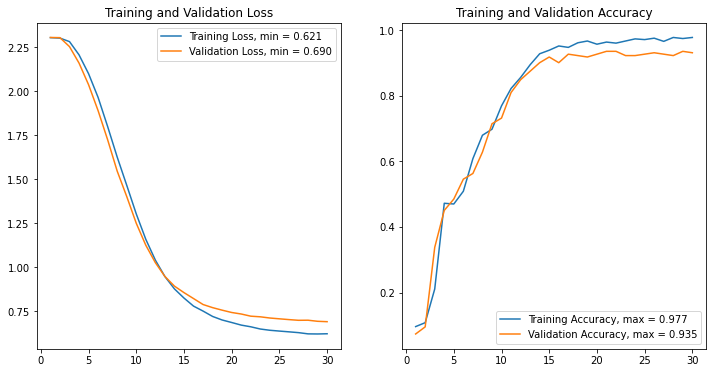

In [0]:
#plot della loss e della accuracy durante il training
plt.figure(figsize=(12, 6))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
max_acc = np.amax(acc)
max_val_acc = np.amax(val_acc)

loss=history.history['loss']
val_loss=history.history['val_loss']
min_loss = np.amin(loss)
min_val_loss = np.amin(val_loss)

epochs_range = range(1, len(loss) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss, min = %.3f'%min_loss)
plt.plot(epochs_range, val_loss, label='Validation Loss, min = %.3f'%min_val_loss)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy, max = %.3f'%max_acc)
plt.plot(epochs_range, val_acc, label='Validation Accuracy, max = %.3f'%max_val_acc)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

In [0]:
#checks accuracy and loss on test sample
model.load_weights('mycnn_best')
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)

29/29 - 0s - loss: 0.7156 - accuracy: 0.9171

Test loss: 0.7155731916427612

Test accuracy: 0.9171270728111267


**Visualizzazione rappresentazioni apprese dalla CNN**

*   visualizzazione dell'uscita delle attivazioni dei vari layes 
*   visualizzazione dei filtri appresi dalla rete
*   Heatmaps


(100, 100, 3)


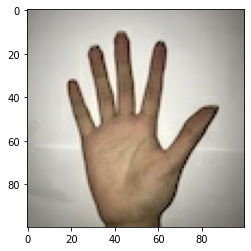

In [0]:
#visualizzazione dell'uscita delle attivazioni dei vari layes

#implementazione:
# 1 si prende un'immagine di esempio (di quelle del validation/test set)
# 2 si costruisce un modello che prende l'immagine in input e restituisce tensori contenenti le uscite di tutte le
#   funzioni di attivazione dei vary later della rete
# 3 si graficano le attivazioni ottenute ...

from IPython.display import Image
import matplotlib.pyplot as plt
import cv2

#prendiamo un'immagine a caso del validation set
for images,labels in train_ds.take(1):
   immagine = images[6].numpy().astype("uint8")
print(immagine.shape)

plt.imshow(immagine) 
plt.show()

In [0]:
#salviamo i nomi di tutti i layers della rete nella lista layer_names
layer_names = []
for layer in model.layers[:25]:
    layer_names.append(layer.name)
print(layer_names)

# estraiamo gli output da tutti i 20 layers della nostra rete
layer_outputs = [layer.output for layer in model.layers[:25]]

# instanziamo un semplice modello keras che prende l'immagine in input e restituisce 
# tali output (le attivazioni)

activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

['input_135', 'rescaling_27', 'Conv_1', 'LeakyReLU_1', 'MaxPool_1', 'dropout_21', 'Conv_2', 'LeakyReLU_2', 'MaxPool_2', 'dropout_22', 'Conv_3', 'LeakyReLU_3', 'MaxPool_3', 'dropout_23', 'Flatten', 'Dense_1', 'tf_op_layer_Square_18', 'tf_op_layer_Sum_18', 'tf_op_layer_Maximum_18', 'tf_op_layer_Rsqrt_18', 'tf_op_layer_Mul_18', 'ReLU_dense_1', 'Dense_2', 'ReLU_dense_2', 'Output']


In [0]:
#trasformiamo l'immagine in modo che abbia la shape di tensore numpy adatta alla 
#nostra rete (1,100,100,3) con primo indice l'indice di evento (l'immagine singola
#non ha questo primo indice ovviamente)
immagine = np.reshape(immagine, (1,100,100,3))

# e estraiamone le attivazioni
activations = activation_model.predict(immagine)

(1, 98, 98, 16)


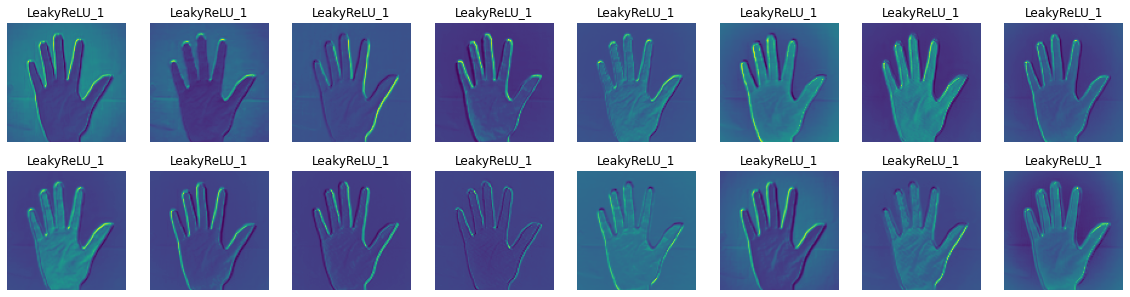

In [0]:
# grafichiamo gli output per il primo layer convoluzionale (è il layer numero 
# 3 (dopo ReLU) nel nostro modello)

first_layer_activation = activations[3]
print(first_layer_activation.shape)

k = 0
plt.figure(figsize=(20, 5), frameon=False)

for i in range(8):
   for j in range(2):
      ax = plt.subplot(2, 8, k + 1, sharex=ax)
      plt.imshow(first_layer_activation[0, :, :, k], cmap='viridis') 
      plt.axis("off")
      plt.grid(False)
      plt.title(layer_names[3])
      k = k + 1

(1, 21, 21, 32)


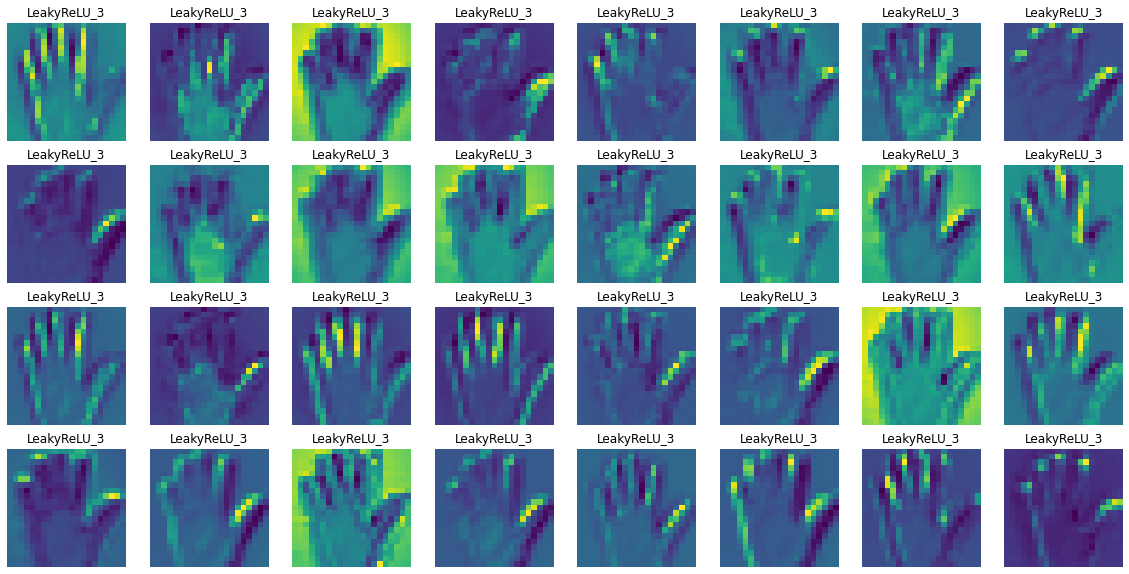

In [0]:
# stessa cosa per il terzo layer convoluzionale (il 13 nella lista)
# sono 32 filtri, per velocità e semplicità ne grafichiamo solo i primi 
# 8)
tird_layer_activation = activations[11]
print(tird_layer_activation.shape)

k = 0
plt.figure(figsize=(20, 10), frameon=False)

for i in range(8):
  for j in range(4):
    ax = plt.subplot(4, 8, k + 1, sharex=ax)
    plt.imshow(tird_layer_activation[0, :, :, k], cmap='viridis') 
    plt.axis("off")
    plt.grid(False)
    plt.title(layer_names[11])
    k = k + 1

(1, 64)


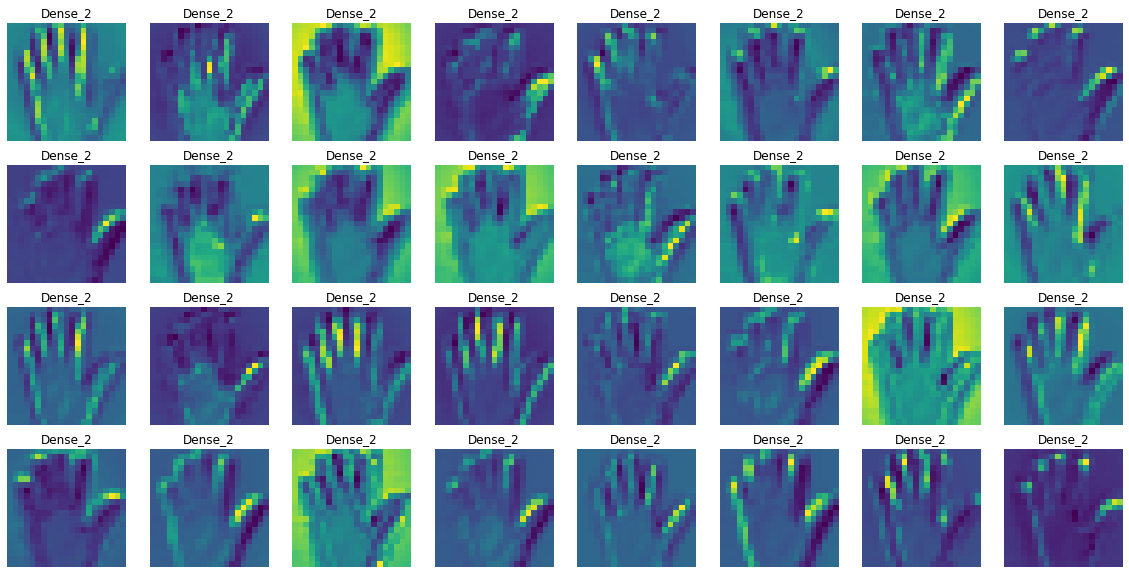

In [0]:
# stessa cosa per il Secondo layer denso (il 13 nella lista)
# sono 32 filtri, per velocità e semplicità ne grafichiamo solo i primi 
# 8)
second_dense_layer_activation = activations[22]
print(second_dense_layer_activation.shape)

k = 0
plt.figure(figsize=(20, 10), frameon=False)

for i in range(8):
  for j in range(4):
    ax = plt.subplot(4, 8, k + 1, sharex=ax)
    plt.imshow(second_dense_layer_activation[0, :, :, k], cmap='viridis') 
    plt.axis("off")
    plt.grid(False)
    plt.title(layer_names[22])
    k = k + 1

In [0]:
#visualizzazione dei filtri appresi

#implementazione:
# 1 si prendono i pesi del layer convoluzionale selezionato  
# 2 si normalizzano i valori tra 0 e 1 per facilitarne la visualizzazione 
# 3 si plottano i risultati

Filtri layer convoluzionale:  Conv_1


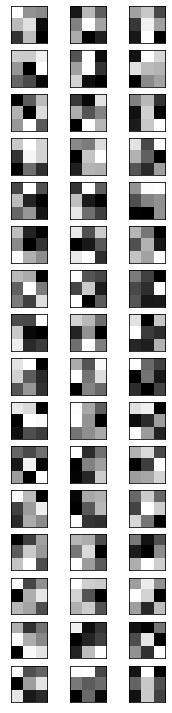

Filtri layer convoluzionale:  Conv_2


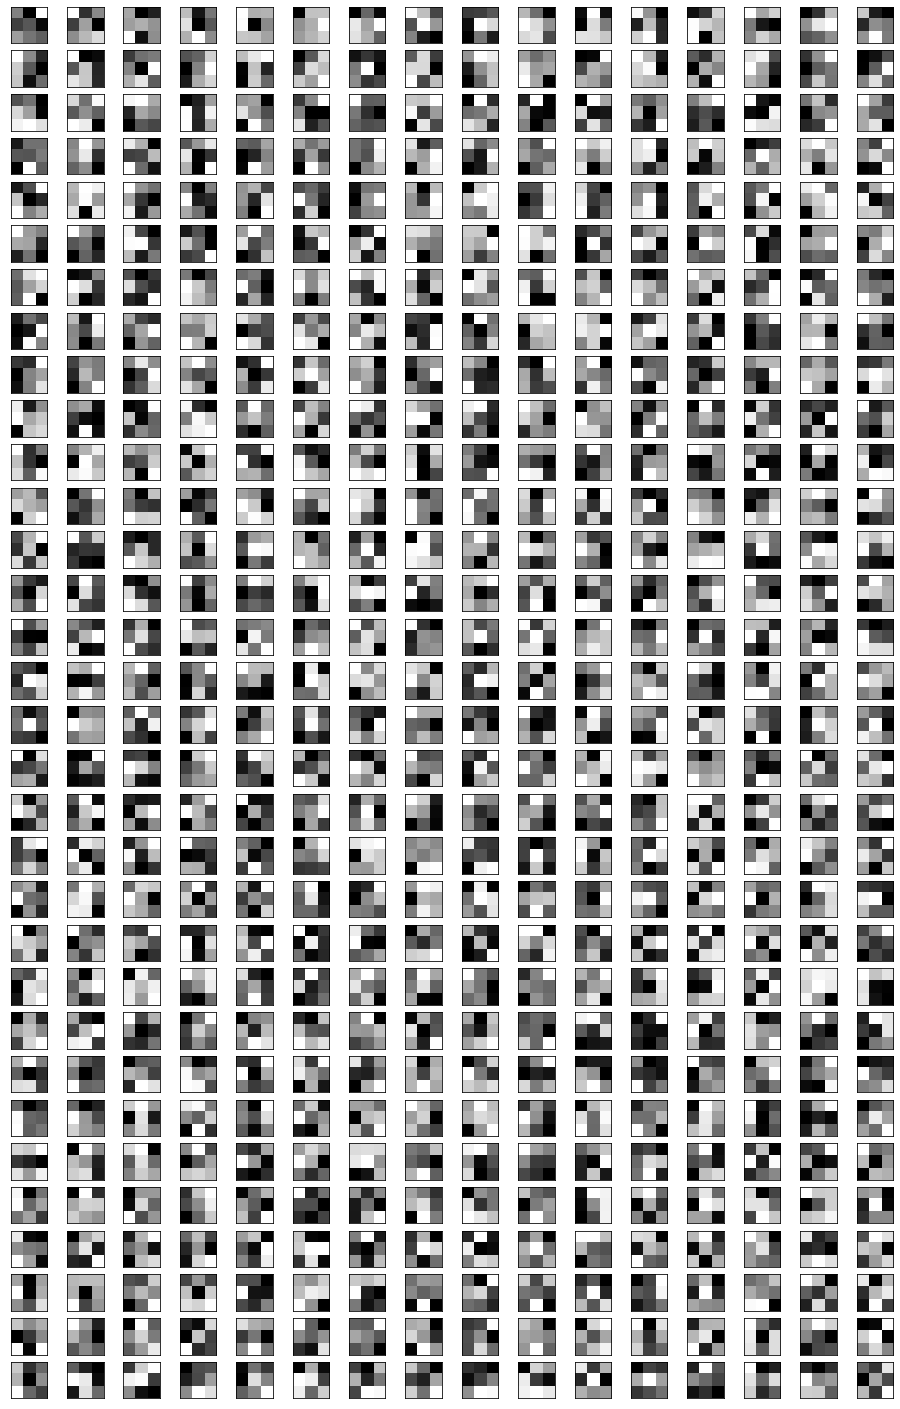

Filtri layer convoluzionale:  Conv_3


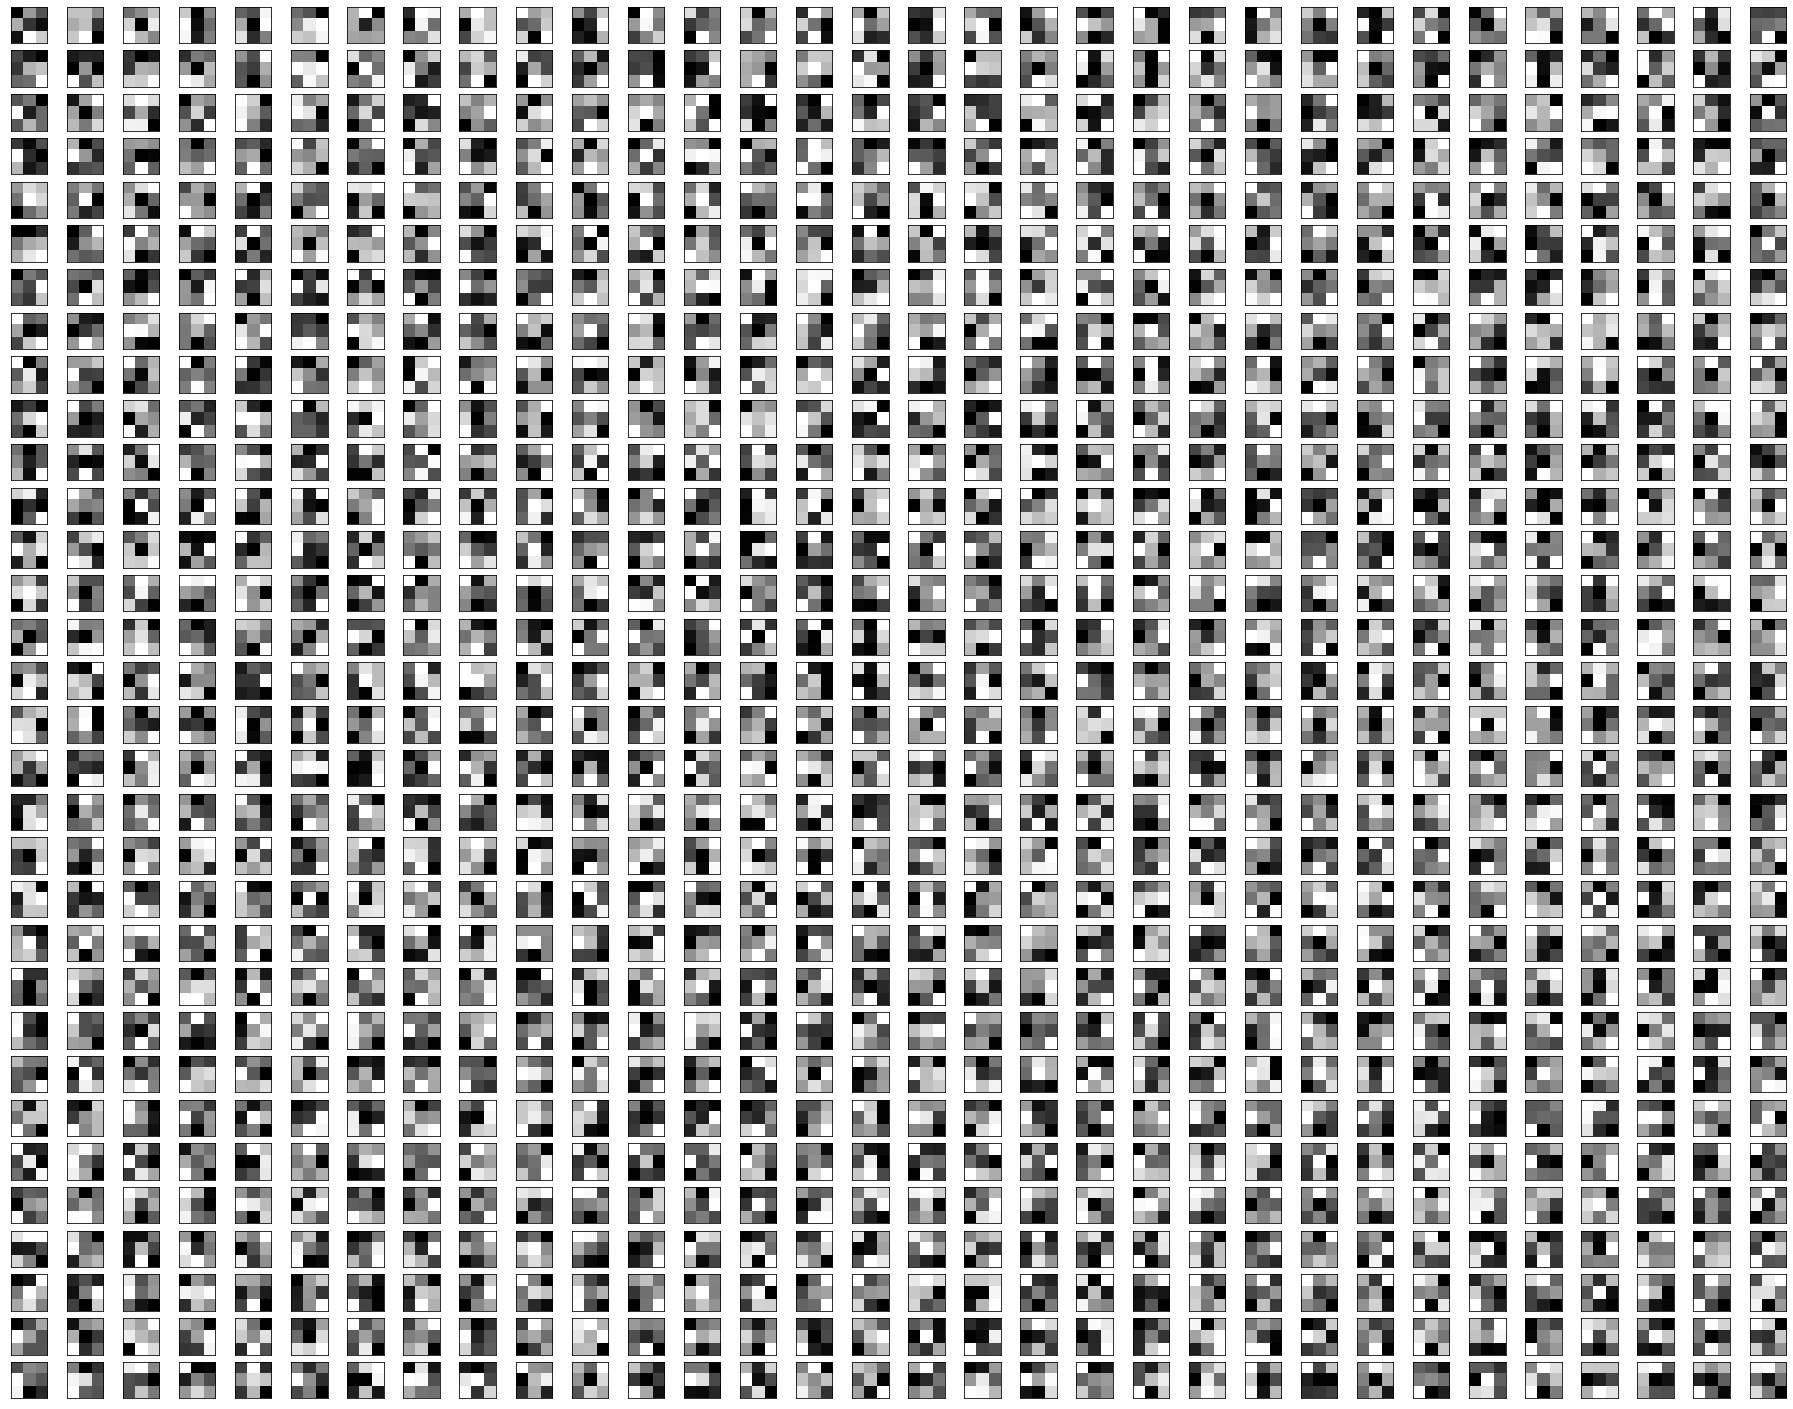

In [0]:
# plot dei filtri
# quadrati scuri indicano pesi piccoli (inibitori) del filtro
# quadrati chiari indicano pesi grandi (eccitatori) del filtro 
# diferenze tra filtri sulla stessa riga significa effetti diversi nei diversi canali in input
# Conv_1 3 canali (RGB), Conv_2 16 filtri in input ...

for layerc in ['Conv_1', 'Conv_2', 'Conv_3']:
    print('Filtri layer convoluzionale: ', layerc)
    # pesi del layer selezionato:
    filters, biases = model.get_layer(layerc).get_weights()
    # numero dei filtri 
    n_filters = filters.shape[3]
    # numero canali 
    n_channels = filters.shape[2]
    # normalizzazione in [0,1] per rendere più chiaro il plot
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    k = 1
    plt.figure(figsize=(n_channels, n_filters*0.8), frameon=False)
    for i in range(n_filters):
        f = filters[:, :, :, i]
        # plot del filtro per ogni canale RGB
        for j in range(n_channels):
            ax = plt.subplot(n_filters, n_channels, k)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(f[:, :, j], cmap='gray')
            k = k + 1

    plt.show()

In [0]:
#Heatmaps (GradCAM: Gradient-based Class Activation Map)

#implementazione (Keras/F.Chollet)
# 1 si prende la mappa di feature in uscita da un dato layer di convoluzione e si pesa 
#   ogni canale di tale mappa con il gradiente della classe rispetto a quel canale (i.e. 
#   si calcola la mappa spaziale di quanto una data immagine di input attiva una data classe)

In [0]:
#Grad-CAM Algorithm (https://arxiv.org/pdf/1610.02391.pdf)

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


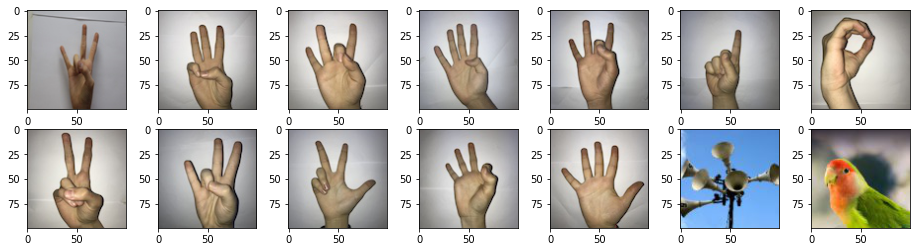

In [0]:
#prendiamo un'immagine a caso del validation set
import matplotlib.image as mpimg
plt.close()

images = ['IMG_1216.JPG','IMG_4065.JPG','IMG_4231.JPG','IMG_4310.JPG','IMG_4774.JPG','IMG_4797.JPG','IMG_5193.JPG','IMG_5299.JPG','IMG_5579.JPG','IMG_5648.JPG','IMG_5765.JPG','IMG_5996.JPG','image_1.jpg','image_2.jpg']
img_origlist = []

fig, axarr = plt.subplots(nrows=2, ncols=7, figsize = (8*2,4))

for i,j in enumerate(images):
  if i<7:
    img_origin = keras.utils.get_file(images[i], 'http://giagu.web.cern.ch/giagu/CERN/'+images[i])
    img_origlist.append(img_origin)
    img=mpimg.imread(img_origlist[i])
    axarr[0,i].imshow(img)
  else:
    img_origin = keras.utils.get_file(images[i], 'http://giagu.web.cern.ch/giagu/CERN/'+images[i])
    img_origlist.append(img_origin)
    img=mpimg.imread(img_origlist[i])
    axarr[1,i-7].imshow(img)

plt.show()


In [0]:
# Preparazione immagine
from IPython.display import Image
import cv2

save_path = []
predictions = np.zeros(14)

last_conv_layer_name = "MaxPool_3"
classifier_layer_names = [
    "Flatten",
    "Dense_1",
    "ReLU_dense_1",
    "Dense_2",
    "ReLU_dense_2",
    "Output",
]

for i,j in enumerate(img_origlist):
  img_size = (100,100)
  img_tmp = keras.preprocessing.image.load_img(img_origlist[i], target_size=img_size)
  img_inp = keras.preprocessing.image.img_to_array(img_tmp) #->float32 Numpy array
  img_inp = np.expand_dims(img_inp, axis=0) #(100,100,3) -> (1,100,100,3)
  preds = model.predict(img_inp)
  predictions[i] = np.argmax(preds)
  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(
      img_inp, model, last_conv_layer_name, classifier_layer_names
  )

  img = cv2.imread(img_origlist[i])

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = np.uint8(255 * heatmap)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = heatmap * 0.4 + img

  save_path.append("result_cam"+str(i+1)+".jpg")
  cv2.imwrite(save_path[i], superimposed_img)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


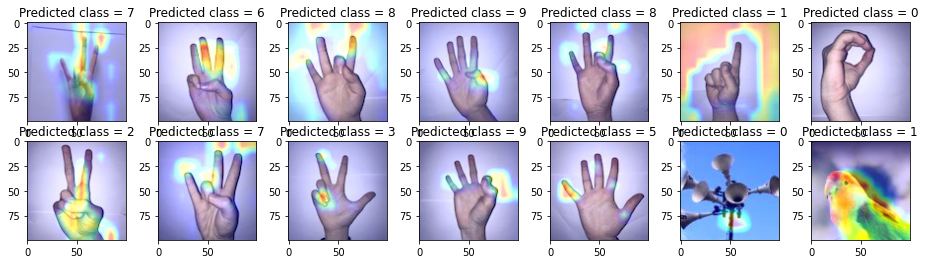

In [0]:
plt.close()

fig, axarr = plt.subplots(nrows=2, ncols=7, figsize = (8*2,4))

for i,j in enumerate(images):
  if i<7:    
    img=mpimg.imread(save_path[i])
    axarr[0,i].imshow(img)
    axarr[0,i].set_title('Predicted class = %d'%predictions[i])
  else:
    img=mpimg.imread(save_path[i])
    axarr[1,i-7].imshow(img)
    axarr[1,i-7].set_title('Predicted class = %d'%predictions[i])

plt.show()



#Xception implementation

In [0]:
#Prendiamo la rete Xception addestrata su ImageNet

#estraiamo solo il base-model (i.e. i layer convoluzionali)

base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3), #NOTA IMPORTANTE: una rete pre-trainata lo è stata con immagini di una certa size
    #dovremo modificare opportuanamente le nostre immagini (100,100,3) per accordarsi con l'input
    #voluto
    include_top=False)  # Do not include the ImageNet classifier at the top.

#Congeliamo i layer convoluzionali del modello base
base_model.trainable = False

In [0]:
#Costruiamo un modello di classificazione on top del modello trainato (per esempio
#simile a quello che abbiamo usato per la nostra rete CNN)

inputs_XC = keras.Input(shape=(150, 150, 3))

# Normalizzazione [0,1]
x = layers.experimental.preprocessing.Rescaling(1.0/255)(inputs_XC)

# blocco di feature-extraction dato da Xception

x = base_model(inputs_XC, training=False)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

# Classificatore
x = keras.layers.Dense(64, name='Dense_1')(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)
x = keras.layers.Dense(64, name='Dense_2')(x)
x = keras.layers.ReLU(name='ReLU_dense_2')(x)
outputs_XC = keras.layers.Dense(10, activation='softmax', name='Output')(x)

#definizione del modello
model_XC = keras.Model(inputs=inputs_XC, outputs=outputs_XC, name='FineTuned_XC')

#printout il summary del modello
model_XC.summary()

Model: "FineTuned_XC"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_165 (InputLayer)       [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
Flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
Dense_1 (Dense)              (None, 64)                3276864   
_________________________________________________________________
ReLU_dense_1 (ReLU)          (None, 64)                0         
_________________________________________________________________
Dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
ReLU_dense_2 (ReLU)          (None, 64)               

In [0]:
# preprocessamento dei dati
#definiamo la size delle immagini (sono 100x100) e la batch size con cui vengono lette dal disco in gruppi
image_size = (100, 100)
batch_size = 32

#80% delle immagini usate per training - 20% per validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=4321,
    image_size=image_size,
    batch_size=batch_size,
)
vali_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=4321,
    image_size=image_size,
    batch_size=batch_size,
)

#lettura dataset di test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset_test",
    label_mode='categorical',
    seed=4321,
    image_size=image_size,
    batch_size=batch_size,
)

#trasformiamoli nella size richiesta
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
vali_ds = vali_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

#ottimizzazione dei dataset caching e prefetching per I/O su disco
train_ds = train_ds.prefetch(buffer_size=32)
vali_ds = vali_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

Found 1157 files belonging to 10 classes.
Using 926 files for training.
Found 1157 files belonging to 10 classes.
Using 231 files for validation.
Found 905 files belonging to 10 classes.


In [0]:
# Compilazione del modello
LR_ST=1e-3
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
EAGERLY = False

model_XC.compile(optimizer=OPTIMIZER,
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

lr_scheduler4 = keras.callbacks.LearningRateScheduler(lr_decay)
model_checkpoint4 = keras.callbacks.ModelCheckpoint(
        filepath='XCcnn_best',
        monitor='val_accuracy',
        save_weights_only=True, 
        save_best_only=True,
        save_freq='epoch')

# metto tutte le callback in una lista
callbacks = [ lr_scheduler, model_checkpoint4 ]    

history = model_XC.fit(train_ds, epochs=20,
                    validation_data=vali_ds, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/20
29/29 [==============================] - 3s 119ms/step - loss: 65.8137 - accuracy: 0.1890 - val_loss: 13.8101 - val_accuracy: 0.2381
Epoch 2/20
29/29 [==============================] - 3s 94ms/step - loss: 6.2199 - accuracy: 0.3909 - val_loss: 3.3609 - val_accuracy: 0.3723
Epoch 3/20
29/29 [==============================] - 3s 95ms/step - loss: 2.7796 - accuracy: 0.4449 - val_loss: 2.0157 - val_accuracy: 0.5238
Epoch 4/20
29/29 [==============================] - 3s 95ms/step - loss: 1.4709 - accuracy: 0.5983 - val_loss: 1.6534 - val_accuracy: 0.5758
Epoch 5/20
29/29 [==============================] - 2s 83ms/step - loss: 1.0719 - accuracy: 0.6382 - val_loss: 1.5892 - val_accuracy: 0.5368
Epoch 6/20
29/29 [==============================] - 3s 97ms/step - loss: 0.8721 - accuracy: 0.7084 - val_loss: 1.0647 - val_accuracy: 0.6710
Epoch 7/20
29/29 [==============================] - 3s 98ms/step - loss: 0.7940 - accuracy: 0.7214 - val_loss: 1.0584 - val_accuracy: 0.6797
Epoch 8/20

In [0]:
# carichiamo i parametri del modello migliore sul validation set 
model_XC.load_weights('XCcnn_best')

In [0]:
# seguito infine da un breve round di fine tuning globale

# decongeliamo i pesi del modello base della VGG16
#
# NOTA importante: manteniamo 'training=False' quando chiamiamo il la rete nel 
# modello, questo serve per fare in modo che i batch-normlisation layer contenuti
# in VGG16 non aggiornino la loro batch statistic distruggendo quanto appreso in 
# precedenza (per una spiegazione più dettagliata vedere: https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)

base_model.trainable = True
model_XC.summary()

LR_ST=1e-5 #usiamo un learning rate spinto e fisso visto che vogliamo mantenere il training nei dintorni del minimo trovato precedentemente
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
EAGERLY = False

model_XC.compile(optimizer=OPTIMIZER,
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=EAGERLY)

callbacks = [ model_checkpoint4 ]    
history = model_XC.fit(train_ds, epochs=20,
                    validation_data=vali_ds, shuffle=True, verbose=1,
                    callbacks=callbacks)

Model: "FineTuned_XC"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_165 (InputLayer)       [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
Flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
Dense_1 (Dense)              (None, 64)                3276864   
_________________________________________________________________
ReLU_dense_1 (ReLU)          (None, 64)                0         
_________________________________________________________________
Dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
ReLU_dense_2 (ReLU)          (None, 64)               

In [0]:
#checks accuracy and loss on test sample
model_XC.load_weights('XCcnn_best')
test_loss, test_acc = model_XC.evaluate(test_ds, verbose=2)
print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)

29/29 - 1s - loss: 0.6633 - accuracy: 0.8133

Test loss: 0.663255512714386

Test accuracy: 0.8132596611976624


#Resnet101

In [0]:
#Prendiamo la rete Resnet addestrata su ImageNet

#estraiamo solo il base-model (i.e. i layer convoluzionali)

base_model = keras.applications.ResNet101(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3), #NOTA IMPORTANTE: una rete pre-trainata lo è stata con immagini di una certa size
    #dovremo modificare opportuanamente le nostre immagini (100,100,3) per accordarsi con l'input
    #voluto
    include_top=False)  # Do not include the ImageNet classifier at the top.

#Congeliamo i layer convoluzionali del modello base
base_model.trainable = False

In [0]:
#Costruiamo un modello di classificazione on top del modello trainato (per esempio
#simile a quello che abbiamo usato per la nostra rete CNN)

inputs_res = keras.Input(shape=(224, 224, 3))

# Normalizzazione [0,1]
x = layers.experimental.preprocessing.Rescaling(1.0/255)(inputs_res)

# blocco di feature-extraction dato da Xception

x = base_model(inputs_res, training=False)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

# Classificatore
x = keras.layers.Dense(64, name='Dense_1')(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)
x = keras.layers.Dense(64, name='Dense_2')(x)
x = keras.layers.ReLU(name='ReLU_dense_2')(x)
outputs_res = keras.layers.Dense(10, activation='softmax', name='Output')(x)

#definizione del modello
model_res = keras.Model(inputs=inputs_res, outputs=outputs_res, name='FineTuned_ResNet101')

#printout il summary del modello
model_res.summary()

Model: "FineTuned_ResNet101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_167 (InputLayer)       [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet101 (Functional)       (None, 7, 7, 2048)        42658176  
_________________________________________________________________
Flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
Dense_1 (Dense)              (None, 64)                6422592   
_________________________________________________________________
ReLU_dense_1 (ReLU)          (None, 64)                0         
_________________________________________________________________
Dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
ReLU_dense_2 (ReLU)          (None, 64)        

In [0]:
# preprocessamento dei dati
#definiamo la size delle immagini (sono 100x100) e la batch size con cui vengono lette dal disco in gruppi
image_size = (100, 100)
batch_size = 32

#80% delle immagini usate per training - 20% per validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=4321,
    image_size=image_size,
    batch_size=batch_size,
)
vali_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=4321,
    image_size=image_size,
    batch_size=batch_size,
)

#lettura dataset di test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset_test",
    label_mode='categorical',
    seed=4321,
    image_size=image_size,
    batch_size=batch_size,
)

#trasformiamoli nella size richiesta
size = (224, 224)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
vali_ds = vali_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

#ottimizzazione dei dataset caching e prefetching per I/O su disco
train_ds = train_ds.prefetch(buffer_size=32)
vali_ds = vali_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

Found 1157 files belonging to 10 classes.
Using 926 files for training.
Found 1157 files belonging to 10 classes.
Using 231 files for validation.
Found 905 files belonging to 10 classes.


In [0]:
# Compilazione del modello
LR_ST=1e-3
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
EAGERLY = False

model_res.compile(optimizer=OPTIMIZER,
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

lr_scheduler3 = keras.callbacks.LearningRateScheduler(lr_decay)
model_checkpoint3 = keras.callbacks.ModelCheckpoint(
        filepath='rescnn_best',
        monitor='val_accuracy',
        save_weights_only=True, 
        save_best_only=True,
        save_freq='epoch')

# metto tutte le callback in una lista
callbacks = [ lr_scheduler, model_checkpoint3 ]    

history = model_res.fit(train_ds, epochs=20,
                    validation_data=vali_ds, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/20
29/29 [==============================] - 6s 212ms/step - loss: 5.1926 - accuracy: 0.4957 - val_loss: 0.9157 - val_accuracy: 0.7706
Epoch 2/20
29/29 [==============================] - 5s 158ms/step - loss: 0.4077 - accuracy: 0.9147 - val_loss: 0.7405 - val_accuracy: 0.8182
Epoch 3/20
29/29 [==============================] - 5s 167ms/step - loss: 0.1578 - accuracy: 0.9600 - val_loss: 0.3913 - val_accuracy: 0.8874
Epoch 4/20
29/29 [==============================] - 4s 123ms/step - loss: 0.0362 - accuracy: 0.9881 - val_loss: 0.4081 - val_accuracy: 0.8745
Epoch 5/20
29/29 [==============================] - 5s 157ms/step - loss: 0.0105 - accuracy: 0.9989 - val_loss: 0.3058 - val_accuracy: 0.9048
Epoch 6/20
29/29 [==============================] - 4s 155ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.2533 - val_accuracy: 0.9091
Epoch 7/20
29/29 [==============================] - 5s 161ms/step - loss: 6.7712e-04 - accuracy: 1.0000 - val_loss: 0.2343 - val_accuracy: 0.9221
Ep

In [0]:
# carichiamo i parametri del modello migliore sul validation set 
model_res.load_weights('rescnn_best')

In [0]:
# seguito infine da un breve round di fine tuning globale

# decongeliamo i pesi del modello base della VGG16
#
# NOTA importante: manteniamo 'training=False' quando chiamiamo il la rete nel 
# modello, questo serve per fare in modo che i batch-normlisation layer contenuti
# in VGG16 non aggiornino la loro batch statistic distruggendo quanto appreso in 
# precedenza (per una spiegazione più dettagliata vedere: https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)

base_model.trainable = True
model_res.summary()

LR_ST=1e-5 #usiamo un learning rate spinto e fisso visto che vogliamo mantenere il training nei dintorni del minimo trovato precedentemente
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
EAGERLY = False

model_res.compile(optimizer=OPTIMIZER,
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=EAGERLY)

callbacks = [ model_checkpoint2 ]    
history = model_res.fit(train_ds, epochs=20,
                    validation_data=vali_ds, shuffle=True, verbose=1,
                    callbacks=callbacks)

Model: "FineTuned_ResNet101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_167 (InputLayer)       [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet101 (Functional)       (None, 7, 7, 2048)        42658176  
_________________________________________________________________
Flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
Dense_1 (Dense)              (None, 64)                6422592   
_________________________________________________________________
ReLU_dense_1 (ReLU)          (None, 64)                0         
_________________________________________________________________
Dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
ReLU_dense_2 (ReLU)          (None, 64)        

In [0]:
#checks accuracy and loss on test sample
model_res.load_weights('rescnn_best')
test_loss, test_acc = model_res.evaluate(test_ds, verbose=2)
print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)

29/29 - 3s - loss: 0.1815 - accuracy: 0.9547

Test loss: 0.18150010704994202

Test accuracy: 0.9546961188316345
